In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import json
import saliency
tfk  = tf .keras
tfkl = tfk.layers
from utils import *
from guided_ig import *
from tqdm import tqdm
from sklearn.metrics import auc
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter
from insertion_deletion import CausalMetric, gkern
import pickle
import torch
import re

from tensorflow.python.ops import image_ops
from tensorflow.python.ops import io_ops
from tensorflow.python.keras.layers.preprocessing import image_preprocessing

In [2]:
p_xml = '/media/big/imagenet/data/ILSVRC/Annotations/CLS-LOC/val'
p_jpg = '/media/big/imagenet/data/ILSVRC/Data/CLS-LOC/val'
files_xml = sorted(os.listdir(p_xml))
files_jpg = sorted(os.listdir(p_jpg))

In [3]:
with open('imagenet_class_index.json', 'r') as fp:
    label_json = json.loads(fp.read())
labels = np.array([
    [k, *v]
    for k, v in label_json.items()
])

In [4]:
model = tf.keras.applications.InceptionV3()
def grad_func(x, idx):
    x = tf.constant(x)[tf.newaxis]
    with tf.GradientTape() as tape:
        tape.watch(x)
        pred = model(x)
        pred = pred[:, idx]
    return np.squeeze(tape.gradient(pred, x).numpy())

2021-12-12 21:38:24.162400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 21:38:24.167679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 21:38:24.168014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 21:38:24.168638: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### GIG computation and storage

In [161]:
p_save = '/media/big/imagenet/computed-gig'

for f_xml, f_jpg in tqdm(zip(files_xml, files_jpg,
                            # Comment to run
                            []
                            )): 
    with open(f'{p_xml}/{f_xml}') as fp:
        xml = fp.read()

    path = f'{p_jpg}/{f_jpg}'
    img = io_ops.read_file(path)
    img = image_ops.decode_image(
        img, 
        channels = 3, 
        expand_animations = False
    )
    img = image_ops.resize_images_v2(
        img, 
        (299, 299), 
        method = image_preprocessing.get_interpolation('bilinear')
    )
    img = preprocess_iv3(img)[0]
    p5  = model(img[tf.newaxis]).numpy().flatten().argsort()[::-1][:5]
    y   = xml.split('\n')[13][8:-7]
    
    check_match = np.argwhere(labels[p5, 1] == y)
    if len(check_match) > 0:
        check_idx = p5[check_match][0, 0]
        
        # Guided IG
        gig = np.stack([
            unbounded_guided_ig(
                img.numpy(),
                baseline, 
                200, 
                lambda x: grad_func(x, check_idx), 
                0.1
            )
            for baseline in [
                np.zeros_like(img) - 1, # To the model, black is -1
                np.ones_like (img)      # White is 1
            ]
        ])
        
        # Anchored Guided IG (GIG(20))
        gig20 = np.stack([
            anchored_guided_ig(
                img.numpy(),
                baseline, 
                lambda x: grad_func(x, check_idx), 
                200, 
                0.1,
                anchors = 20
            )
            for baseline in [
                np.zeros_like(img) - 1,
                np.ones_like (img)
            ]
        ])
        res = np.concatenate([gig, gig20])
        
        with open(f'{p_save}/{f_xml}-{f_jpg}.pickle', 'wb') as fp:
            pickle.dump({
                'res': res,
                'p5' : p5,
                'y'  : y
            }, fp)

0it [00:00, ?it/s]


### Plotting utility (currently not in use in this notebook)

In [6]:
def bbox_plot(ax, xmin, xmax, ymin, ymax):
    ax.plot([xmin, xmax], [ymin, ymin], 'r')
    ax.plot([xmin, xmin], [ymin, ymax], 'r')
    ax.plot([xmin, xmax], [ymax, ymax], 'r')
    ax.plot([xmax, xmax], [ymin, ymax], 'r')

### Metrics and most attribution methods

In [168]:
# For AUROC
inbox = lambda samples, xmin, xmax, ymin, ymax: (
    (samples > [xmin, ymin]) & 
    (samples < [xmax, ymax])
).all(1)

idxs = np.array([
    (idx, jdx)
    for idx in range(299)
    for jdx in range(299)
])

# For Grad-CAM
model_body = tfk.Model(model.input, model.get_layer('mixed10').output)

# For Insertion and Deletion metrics
klen = 11
ksig = 5
kern = gkern(klen, ksig)
blur = lambda x: torch.nn.functional.conv2d(x, kern, padding=klen//2)

insertion = CausalMetric(model, 'ins', 2000, substrate_fn = blur)
deletion  = CausalMetric(model, 'del', 2000, substrate_fn = torch.zeros_like)


# For RISE
s = 8
p = 0.1
N = 1000
rise_batch = 10
cell_size = np.ceil(np.array((299, 299)) / s)
up_size   = (s + 1) * cell_size

grid  = (np.random.rand(N, s, s) < p).astype('float')
rise_masks = np.zeros((N, 299, 299))
for idx in range(N):
    x = np.random.randint(0, cell_size[0])
    y = np.random.randint(0, cell_size[1])
    rise_masks[idx] = resize(
        grid[idx], 
        up_size,
        order = 1,
        mode  = 'reflect',
        anti_aliasing = False
    )[x : x + 299, y : y + 299]
rise_masks = rise_masks[..., np.newaxis]

# For saving
ig_path   = '/media/big/imagenet/computed-ig'
gxi_path  = '/media/big/imagenet/computed-g-gxi'
gc_path   = '/media/big/imagenet/computed-gc'
rise_path = '/media/big/imagenet/computed-rise'
saved_res = os.listdir(p_save)
ress_auc = []
ress_insertion = []
ress_deletion  = []
for sr in tqdm(saved_res):
    
    # Interference from missclassified experiments
    try:
        xml, jpg = sr[:-7].split('-')
    except:
        pass
    
    xml = f'{p_xml}/{xml}'
    jpg = f'{p_jpg}/{jpg}'
    res = f'{p_save}/{sr}'
    
    # GIG object (with predictions, true label)
    with open(res, 'rb') as fp:
        obj = pickle.load(fp)
    
    # Make sure that bounding box is actually available
    if labels[obj['p5'][0], 1] == obj['y']:
        
        # Get other precomputed attribution methods
        have_ig   = False
        have_gxi  = False
        have_gc   = False
        have_rise = False
        
        try: # IG
            with open(f'{ig_path}/{jpg.split("/")[-1]}.pickle', 'rb') as fp:
                saved_ig = pickle.load(fp)
                igs = saved_ig['igs']
                if len(igs) == 2:
                    have_ig = True
        except:
            pass
        
        try: # Gradient, Gradient x Image
            with open(f'{gxi_path}/{jpg.split("/")[-1]}.pickle', 'rb') as fp:
                saved_gxi = pickle.load(fp)
                grad = saved_gxi['grad']
                gxi  = saved_gxi['gxi']
                have_gxi = True
        except:
            pass
        
        try: # Grad-CAM
            with open(f'{gc_path}/{jpg.split("/")[-1]}.pickle', 'rb') as fp:
                saved_gc = pickle.load(fp)
                gc = saved_gxi['gc']
                have_gc = True
        except:
            pass
        
        try: # RISE
            with open(f'{rise_path}/{jpg.split("/")[-1]}.pickle', 'rb') as fp:
                saved_rise = pickle.load(fp)
                rise = saved_rise['rise']
                have_rise = True
        except:
            pass
    
        # Load image
        img = io_ops.read_file(jpg)
        img = image_ops.decode_image(
            img, 
            channels = 3, 
            expand_animations = False
        )
        img = image_ops.resize_images_v2(
            img, 
            (299, 299), 
            method = image_preprocessing.get_interpolation('bilinear')
        )
        img.set_shape((299, 299, 3))
        img = tfk.applications.inception_v3.preprocess_input(img)

        # Load BBOXes
        with open(xml, 'r') as fp:
            lines = fp.readlines()
        bndbox_idxs = [idx for idx, line in enumerate(lines) if '<bndbox' in line]
        wh = lines[7:9]
        w = int(re.sub('[^0-9]', '', wh[0]))
        h = int(re.sub('[^0-9]', '', wh[1]))
        bbox_idxs = [
            idx for idx, l in enumerate(lines)
            if f'<name>{obj["y"]}' in l
        ]
        boxes = []
        for idx in bbox_idxs:
            box = lines[idx + 5 : idx + 9]
            box = [int(re.sub('[^0-9]', '', b)) for b in box]
            box = [
                round(299 * box[0] / w),
                round(299 * box[2] / w),
                round(299 * box[1] / h),
                round(299 * box[3] / h),
            ]
            boxes.append(box)
        
        best_idx = obj['p5'][0]
        image    = img[tf.newaxis]
        
        # Compute IG
        
        if not have_ig:
            baseline_b = tf.zeros_like(image) - 1
            baseline_w = tf .ones_like(image)

            steps = 200
            batch = 25
            igs   = []
            for baseline in [baseline_b, baseline_w]:
                delta  = (image - baseline) / steps
                alpha  = tf.cast(tf.linspace(0, steps, steps)[:, tf.newaxis, tf.newaxis, tf.newaxis], tf.float32)
                inputs = baseline + (alpha * delta)

                ig = np.zeros_like(image)
                pointer = 0
                while pointer < steps:
                    inp = tf.gather(inputs, tf.range(pointer, pointer + batch))
                    with tf.GradientTape() as tape:
                        tape.watch(inp)
                        pred = model(inp)
                        pred = pred[:, best_idx]
                    grd = tape.gradient(pred, inp)
                    ig += tf.reduce_sum(grd, 0).numpy()
                    pointer += batch
                igs.append(ig)
                
            with open(f'{ig_path}/{jpg.split("/")[-1]}.pickle', 'wb') as fp:
                pickle.dump({'igs': igs}, fp)
              
            
        # Compute Gradient, Gradient x Image
        if not have_gxi:
            
            with tf.GradientTape() as tape:
                tape.watch(image)
                pred = model(image)
                pred = pred[:, best_idx]
            grad = tape.gradient(pred, image)
            gxi  = grad * image
            
            grad = np.squeeze(grad.numpy())
            gxi  = np.squeeze(gxi .numpy())
            
            with open(f'{gxi_path}/{jpg.split("/")[-1]}.pickle', 'wb') as fp:
                pickle.dump({
                    'grad': grad,
                    'gxi' : gxi
                }, fp)
                
        # Compute Grad-CAM
        if not have_gc:
        
            with tf.GradientTape() as tape:
                body_output = model_body(image)
                tape.watch(body_output)
                pred = model.layers[-1](model.layers[-2](body_output))
                pred = pred[:, best_idx]
            gc = tape.gradient(pred, body_output)
            gc = tf.nn.relu(
                tf.reduce_sum(
                    tfkl.GlobalAveragePooling2D()(
                        gc)[tf.newaxis, tf.newaxis] * body_output, 
                    (0, -1)
                )
            )[..., tf.newaxis]
            gc = image_ops.resize_images_v2(
                gc, 
                (299, 299), 
                image_preprocessing.get_interpolation('bilinear')
            )
            
            with open(f'{gc_path}/{jpg.split("/")[-1]}.pickle', 'wb') as fp:
                pickle.dump({
                    'gc': gc
                }, fp)
                
        # Compute RISE
        if not have_rise:
            
            rise = []
            for bidx in range(N // rise_batch):
            
                rmp = rise_masks[bidx * rise_batch : (bidx + 1) * rise_batch]
                rise_tmp = rmp * image
                p_rise = model.predict(rise_tmp, batch_size = rise_batch)
                risep  = np.squeeze((p_rise[:, best_idx].reshape((-1, 1, 1, 1)) * rmp).sum(0))
                rise.append(risep)
                
            rise = np.stack(rise).sum(0)
            
            with open(f'{rise_path}/{jpg.split("/")[-1]}.pickle', 'wb') as fp:
                pickle.dump({
                    'rise': rise
                }, fp)

        # Prepare attributions
        all_attr = (
            obj['res'][0].mean(-1),           # GIG B
            obj['res'][1].mean(-1),           # GIG W
            obj['res'][[0, 1]].mean((0, -1)), # GIG B + W
            obj['res'][2].mean(-1),           # GIG 20 B
            obj['res'][3].mean(-1),           # GIG 20 W
            obj['res'][[2, 3]].mean((0, -1)), # GIG 20 B + W
            igs[0].mean((0, -1)),             # IG B
            igs[1].mean((0, -1)),             # IG W
            np.concatenate(igs).mean((0, -1)),# IG B + W 
            grad.mean(-1),                    # Gradient
            gxi .mean(-1),                    # Gradient x Image
            np.squeeze(gc),                   # Grad-CAM
            rise                              # RISE
        )

        # Compute AUROC
        qs = np.linspace(1, 0, 6)
        res_auc = []
        res_insertion = []
        res_deletion  = []
        for attr_idx, attr in enumerate(all_attr):
            auc_ = []
            for q in qs:

                positive_attr = np.concatenate([
                    idxs, 
                    tf.gather_nd(attr, idxs).numpy()[:, np.newaxis]
                ], 1)
                positive_attr = positive_attr[positive_attr[:, 2] > 0]
                if len(positive_attr) == 0:
                    # Extremely rare edge case
                    # All attributions 0 or below
                    continue
                    # Will very very slightly perturb results
                
                pos = np.argwhere(positive_attr[:, 2] >= np.quantile(positive_attr[:, 2], q)).flatten()
                neg = np.argwhere(positive_attr[:, 2] <  np.quantile(positive_attr[:, 2], q)).flatten()
                TP = inbox(positive_attr[pos, :2], *boxes[0])
                for bx in boxes[1:]:
                    TP |= inbox(positive_attr[pos, :2], *bx)
                FP = ~TP
                FN = inbox(positive_attr[neg, :2], *boxes[0])
                for bx in boxes[1:]:
                    FN |= inbox(positive_attr[neg, :2], *bx)
                TN = ~FN
                TP = TP.sum()
                TN = TN.sum()
                FP = FP.sum()
                FN = FN.sum()
                
                auc_.append((FP / (FP + TN), TP / (TP + FN)))
                
            if len(auc_) > 0:
                # Same extreme edge case as above
                auc_ = np.array(auc_).T
                res_auc.append(auc(auc_[0], auc_[1]))
            
            if attr_idx in [2, 5, 8, 11, 12]:
                res_insertion.append(insertion.single_run(image, attr))
                res_deletion .append(deletion .single_run(image, attr))
            
        ress_auc.append(res_auc)
        ress_insertion.append(res_insertion)
        ress_deletion .append(res_deletion)

 14%|█████▋                                  | 552/3855 [04:11<23:40,  2.33it/s]/tmp/ipykernel_22322/1986916851.py:307: RuntimeWarning: invalid value encountered in long_scalars
  auc_.append((FP / (FP + TN), TP / (TP + FN)))
 97%|█████████████████████████████████████▊ | 3742/3855 [57:38<01:44,  1.08it/s]


KeyboardInterrupt: 

In [171]:
ress_auc_df = pd.DataFrame(ress_auc, columns = [
    'GIG(0) (Black)',
    'GIG(0) (White)',
    'GIG(0) (B + W)',
    'GIG(20) (White)',
    'GIG(20) (Black)',
    'GIG(20) (B + W)',
    'IG (Black)',
    'IG (White)',
    'IG (Black + White)',
    'Gradient',
    'Gradient x Image',
    'Grad-CAM',
    'RISE'
])

ress_insertion_df = pd.DataFrame(ress_insertion, columns = [
    'GIG(0) (B + W)',
    'GIG(20) (B + W)',
    'IG (Black + White)',
    'Grad-CAM',
    'RISE'
])

ress_deletion_df = pd.DataFrame(ress_deletion, columns = [
    'GIG(0) (B + W)',
    'GIG(20) (B + W)',
    'IG (Black + White)',
    'Grad-CAM',
    'RISE'
])

### Results

In [172]:
ress_auc_df.to_csv('results_auc.csv')
ress_auc_df.describe()

,GIG(0) (Black),GIG(0) (White),GIG(0) (B + W),GIG(20) (White),GIG(20) (Black),GIG(20) (B + W),IG (Black),IG (White),IG (Black + White),Gradient,Gradient x Image,Grad-CAM,RISE
count,2784.000000,2786.000000,2786.000000,2784.000000,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000,2783.000000
mean,0.641741,0.656824,0.659076,0.639930,0.641867,0.653732,0.639478,0.637693,0.640527,0.598886,0.571901,0.717010,0.636243
std,0.110560,0.105403,0.106615,0.097111,0.100379,0.098893,0.095105,0.093389,0.094543,0.095337,0.096507,0.161699,0.139981
min,0.168325,0.143934,0.143956,0.221238,0.206434,0.230443,0.214042,0.228775,0.221774,0.256958,0.220005,0.090339,0.121205
25%,0.571817,0.591211,0.591522,0.582830,0.583461,0.597909,0.584614,0.581896,0.585093,0.539899,0.509274,0.624866,0.545929
50%,0.647401,0.659073,0.663577,0.644625,0.648246,0.660999,0.639127,0.638384,0.641266,0.594058,0.562479,0.745505,0.646170
75%,0.715509,0.726525,0.728731,0.705522,0.708153,0.719513,0.698670,0.696241,0.700205,0.656040,0.635645,0.840263,0.734719
max,0.903879,0.904866,0.905100,0.906471,0.900007,0.890729,0.896355,0.892292,0.894385,0.879892,0.880095,0.977476,0.961401


In [174]:
ress_insertion_df.to_csv('results_insertion.csv')
ress_insertion_df.describe()

,GIG(0) (B + W),GIG(20) (B + W),IG (Black + White),Grad-CAM,RISE
count,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000
mean,0.619337,0.705133,0.519023,0.781672,0.773467
std,0.302606,0.251217,0.326882,0.199673,0.219802
min,0.005213,0.015505,0.002791,0.026900,0.017928
25%,0.354401,0.541398,0.198723,0.688495,0.666592
50%,0.702920,0.786408,0.529521,0.851592,0.859602
75%,0.886542,0.915767,0.837523,0.928409,0.934916
max,1.000000,1.000000,0.999999,1.000000,1.000000


In [175]:
ress_deletion_df.to_csv('results_deletion.csv')
ress_deletion_df.describe()

,GIG(0) (B + W),GIG(20) (B + W),IG (Black + White),Grad-CAM,RISE
count,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000
mean,0.177911,0.093922,0.194372,0.141704,0.157557
std,0.227617,0.160711,0.196352,0.130518,0.140131
min,0.001270,0.000983,0.001297,0.001164,0.001103
25%,0.014141,0.011864,0.046668,0.043937,0.049589
50%,0.057859,0.025917,0.121492,0.101884,0.116158
75%,0.273846,0.089014,0.284455,0.201740,0.225840
max,0.943562,0.951936,0.962316,0.867439,0.900082


### Same as above - but for missclassified images
Mostly copy-pasted of final version for convenience.

In [176]:
gig_path = '/media/big/imagenet/computed-gig'

compute_counter = 0

ress_auc_mc = []
ress_insertion_mc = []
ress_deletion_mc  = []

for xml, jpg in tqdm(zip(files_xml, files_jpg)):
    xml = f'{p_xml}/{xml}'
    jpg = f'{p_jpg}/{jpg}'
    
    # Load image
    img = io_ops.read_file(jpg)
    img = image_ops.decode_image(
        img, 
        channels = 3, 
        expand_animations = False
    )
    img = image_ops.resize_images_v2(
        img, 
        (299, 299), 
        method = image_preprocessing.get_interpolation('bilinear')
    )
    img.set_shape((299, 299, 3))
    img = tfk.applications.inception_v3.preprocess_input(img)
    image = img[tf.newaxis]

    # Load BBOXes
    with open(xml, 'r') as fp:
        lines = fp.readlines()
    y = lines[13][8:-8]
    bndbox_idxs = [idx for idx, line in enumerate(lines) if '<bndbox' in line]
    wh = lines[7:9]
    w = int(re.sub('[^0-9]', '', wh[0]))
    h = int(re.sub('[^0-9]', '', wh[1]))
    bbox_idxs = [
        idx for idx, l in enumerate(lines)
        if f'<name>{y}' in l
    ]
    boxes = []
    for idx in bbox_idxs:
        box = lines[idx + 5 : idx + 9]
        box = [int(re.sub('[^0-9]', '', b)) for b in box]
        box = [
            round(299 * box[0] / w),
            round(299 * box[2] / w),
            round(299 * box[1] / h),
            round(299 * box[3] / h),
        ]
        boxes.append(box)

    pred = model(image)
    p5   = pred.numpy().flatten().argsort()[::-1][:5]
    best_idx = p5[0]
    
    if not (y == labels[p5, 1]).any():
       
        compute_counter += 1
        if compute_counter % 10 == 0:
            print(f'Found {compute_counter} so far')
        
        # Get precomputed attribution methods
        have_gig  = False
        have_ig   = False
        have_gxi  = False
        have_gc   = False
        have_rise = False
        
        try: # GIG
            with open(f'{gig_path}/{jpg.split("/")[-1]}.pickle', 'rb') as fp:
                saved_gig = pickle.load(fp)
                gigs = saved_gig['gigs']
                have_gig = True
        except:
            pass
        
        try: # IG
            with open(f'{ig_path}/{jpg.split("/")[-1]}.pickle', 'rb') as fp:
                saved_ig = pickle.load(fp)
                igs = saved_ig['igs']
                if len(igs) == 2:
                    have_ig = True
        except:
            pass
        
        try: # Gradient, Gradient x Image
            with open(f'{gxi_path}/{jpg.split("/")[-1]}.pickle', 'rb') as fp:
                saved_gxi = pickle.load(fp)
                grad = saved_gxi['grad']
                gxi  = saved_gxi['gxi']
                have_gxi = True
        except:
            pass
        
        try: # Grad-CAM
            with open(f'{gc_path}/{jpg.split("/")[-1]}.pickle', 'rb') as fp:
                saved_gc = pickle.load(fp)
                gc = saved_gxi['gc']
                have_gc = True
        except:
            pass
        
        try: # RISE
            with open(f'{rise_path}/{jpg.split("/")[-1]}.pickle', 'rb') as fp:
                saved_rise = pickle.load(fp)
                rise = saved_rise['rise']
                have_rise = True
        except:
            pass
    
       # Compute GIG
        
        gig = np.stack([
            unbounded_guided_ig(
                img.numpy(),
                baseline, 
                200, 
                lambda x: grad_func(x, best_idx), 
                0.1
            )
            for baseline in [
                np.zeros_like(img) - 1, 
                np.ones_like (img) 
            ]
        ])
        
        gig20 = np.stack([
            anchored_guided_ig(
                img.numpy(),
                baseline, 
                lambda x: grad_func(x, best_idx), 
                200, 
                0.1,
                anchors = 20
            )
            for baseline in [
                np.zeros_like(img) - 1,
                np.ones_like (img)
            ]
        ])
        gigs = np.concatenate([gig, gig20])
        with open(f'{gig_path}/{jpg.split("/")[-1]}.pickle', 'wb') as fp:
            pickle.dump({'gigs': gigs}, fp)
        
        # Compute IG
        
        if not have_ig:
            baseline_b = tf.zeros_like(image) - 1
            baseline_w = tf .ones_like(image)

            steps = 200
            batch = 25
            igs   = []
            for baseline in [baseline_b, baseline_w]:
                delta  = (image - baseline) / steps
                alpha  = tf.cast(tf.linspace(0, steps, steps)[:, tf.newaxis, tf.newaxis, tf.newaxis], tf.float32)
                inputs = baseline + (alpha * delta)

                ig = np.zeros_like(image)
                pointer = 0
                while pointer < steps:
                    inp = tf.gather(inputs, tf.range(pointer, pointer + batch))
                    with tf.GradientTape() as tape:
                        tape.watch(inp)
                        pred = model(inp)
                        pred = pred[:, best_idx]
                    grd = tape.gradient(pred, inp)
                    ig += tf.reduce_sum(grd, 0).numpy()
                    pointer += batch
                igs.append(ig)
                
            with open(f'{ig_path}/{jpg.split("/")[-1]}.pickle', 'wb') as fp:
                pickle.dump({'igs': igs}, fp)
              
            
        # Compute Gradient, Gradient x Image
        if not have_gxi:
            
            with tf.GradientTape() as tape:
                tape.watch(image)
                pred = model(image)
                pred = pred[:, best_idx]
            grad = tape.gradient(pred, image)
            gxi  = grad * image
            
            grad = np.squeeze(grad.numpy())
            gxi  = np.squeeze(gxi .numpy())
            
            with open(f'{gxi_path}/{jpg.split("/")[-1]}.pickle', 'wb') as fp:
                pickle.dump({
                    'grad': grad,
                    'gxi' : gxi
                }, fp)
                
        # Compute Grad-CAM
        if not have_gc:
        
            with tf.GradientTape() as tape:
                body_output = model_body(image)
                tape.watch(body_output)
                pred = model.layers[-1](model.layers[-2](body_output))
                pred = pred[:, best_idx]
            gc = tape.gradient(pred, body_output)
            gc = tf.nn.relu(
                tf.reduce_sum(
                    tfkl.GlobalAveragePooling2D()(
                        gc)[tf.newaxis, tf.newaxis] * body_output, 
                    (0, -1)
                )
            )[..., tf.newaxis]
            gc = image_ops.resize_images_v2(
                gc, 
                (299, 299), 
                image_preprocessing.get_interpolation('bilinear')
            )
            
            with open(f'{gc_path}/{jpg.split("/")[-1]}.pickle', 'wb') as fp:
                pickle.dump({
                    'gc': gc
                }, fp)
                
        # Compute RISE
        if not have_rise:
            
            rise = []
            for bidx in range(N // rise_batch):
            
                rmp = rise_masks[bidx * rise_batch : (bidx + 1) * rise_batch]
                rise_tmp = rmp * image
                p_rise = model.predict(rise_tmp, batch_size = rise_batch)
                risep  = np.squeeze((p_rise[:, best_idx].reshape((-1, 1, 1, 1)) * rmp).sum(0))
                rise.append(risep)
                
            rise = np.stack(rise).sum(0)
            
            with open(f'{rise_path}/{jpg.split("/")[-1]}.pickle', 'wb') as fp:
                pickle.dump({
                    'rise': rise
                }, fp)

        # Prepare attributions
        all_attr = (
            gigs[0].mean(-1),           # GIG B
            gigs[1].mean(-1),           # GIG W
            gigs[[0, 1]].mean((0, -1)), # GIG B + W
            gigs[2].mean(-1),           # GIG 20 B
            gigs[3].mean(-1),           # GIG 20 W
            gigs[[2, 3]].mean((0, -1)), # GIG 20 B + W
            igs[0].mean((0, -1)),             # IG B
            igs[1].mean((0, -1)),             # IG W
            np.concatenate(igs).mean((0, -1)),# IG B + W 
            grad.mean(-1),                    # Gradient
            gxi .mean(-1),                    # Gradient x Image
            np.squeeze(gc),                   # Grad-CAM
            rise                              # RISE
        )

        # Compute AUROC
        qs = np.linspace(1, 0, 6)
        res_auc = []
        res_insertion = []
        res_deletion  = []
        for attr_idx, attr in enumerate(all_attr):
            auc_ = []
            for q in qs:

                positive_attr = np.concatenate([
                    idxs, 
                    tf.gather_nd(attr, idxs).numpy()[:, np.newaxis]
                ], 1)
                positive_attr = positive_attr[positive_attr[:, 2] > 0]
                if len(positive_attr) == 0:
                    # Extremely rare edge case
                    # All attributions 0 or below
                    continue
                    # Will very very slightly perturb results
                
                pos = np.argwhere(positive_attr[:, 2] >= np.quantile(positive_attr[:, 2], q)).flatten()
                neg = np.argwhere(positive_attr[:, 2] <  np.quantile(positive_attr[:, 2], q)).flatten()
                TP = inbox(positive_attr[pos, :2], *boxes[0])
                for bx in boxes[1:]:
                    TP |= inbox(positive_attr[pos, :2], *bx)
                FP = ~TP
                FN = inbox(positive_attr[neg, :2], *boxes[0])
                for bx in boxes[1:]:
                    FN |= inbox(positive_attr[neg, :2], *bx)
                TN = ~FN
                TP = TP.sum()
                TN = TN.sum()
                FP = FP.sum()
                FN = FN.sum()
                
                auc_.append((FP / (FP + TN), TP / (TP + FN)))
                
            if len(auc_) > 0:
                # Same extreme edge case as above
                auc_ = np.array(auc_).T
                res_auc.append(auc(auc_[0], auc_[1]))
            
            if attr_idx in [2, 5, 8, 11, 12]:
                res_insertion.append(insertion.single_run(image, attr))
                res_deletion .append(deletion .single_run(image, attr))
            
        ress_auc_mc.append(res_auc)
        ress_insertion_mc.append(res_insertion)
        ress_deletion_mc .append(res_deletion)

138it [15:41,  1.37s/it]

Found 10 so far


294it [34:15,  8.24s/it]

Found 20 so far


511it [53:27, 12.02s/it]

Found 30 so far


665it [1:12:33, 15.40s/it]

Found 40 so far


758it [1:31:36,  6.91s/it]

Found 50 so far


924it [1:50:45,  2.53it/s]

Found 60 so far


1135it [2:09:49, 17.21s/it]

Found 70 so far


1319it [2:29:01,  9.09s/it]

Found 80 so far


1419it [2:48:01,  4.82s/it]

Found 90 so far


1505it [3:07:05,  2.45s/it]

Found 100 so far


1585it [3:26:09,  1.24s/it]

Found 110 so far


1677it [3:45:17,  7.58s/it]

Found 120 so far


1832it [4:04:20, 17.50it/s]

Found 130 so far


1974it [4:23:24,  1.03s/it]

Found 140 so far


2105it [4:42:27,  5.81it/s]

Found 150 so far


2260it [5:01:29,  1.05s/it]

Found 160 so far


2453it [5:20:35,  7.23it/s]

Found 170 so far


2646it [5:39:44,  1.52s/it]

Found 180 so far


2758it [5:58:45,  1.23s/it]

Found 190 so far


2919it [6:17:50,  7.01s/it]

Found 200 so far


3013it [6:36:49, 37.08s/it]

Found 210 so far


3055it [6:42:03,  7.90s/it]


_NotOkStatusException: InvalidArgumentError: PyLong_AsSize_t failure

In [177]:
ress_insertion_df_mc = pd.DataFrame(ress_insertion_mc, columns = [
    'GIG(0) (B + W)',
    'GIG(20) (B + W)',
    'IG (Black + White)',
    'Grad-CAM',
    'RISE'
])

ress_deletion_df_mc = pd.DataFrame(ress_deletion_mc, columns = [
    'GIG(0) (B + W)',
    'GIG(20) (B + W)',
    'IG (Black + White)',
    'Grad-CAM',
    'RISE'
])

In [178]:
ress_insertion_df_mc.to_csv('results_insertion_mc')
ress_insertion_df_mc.describe()

,GIG(0) (B + W),GIG(20) (B + W),IG (Black + White),Grad-CAM,RISE
count,211.000000,211.000000,211.000000,211.000000,211.000000
mean,0.206681,0.374272,0.125838,0.377398,0.343729
std,0.228528,0.255470,0.198077,0.268117,0.279814
min,0.001812,0.004530,0.001298,0.012519,0.010968
25%,0.040715,0.148635,0.015454,0.137428,0.089181
50%,0.110886,0.330999,0.042953,0.326960,0.240176
75%,0.309494,0.573646,0.123606,0.582525,0.550039
max,0.994390,0.995570,0.984358,0.998091,0.996942


In [179]:
ress_deletion_df_mc.to_csv('results_deletion_mc')
ress_deletion_df_mc.describe()

,GIG(0) (B + W),GIG(20) (B + W),IG (Black + White),Grad-CAM,RISE
count,211.000000,211.000000,211.000000,211.000000,211.000000
mean,0.048153,0.025582,0.074698,0.039269,0.047166
std,0.124960,0.079700,0.133583,0.062465,0.070812
min,0.000804,0.000783,0.000815,0.000911,0.001207
25%,0.003480,0.003070,0.007519,0.007141,0.007686
50%,0.007446,0.006120,0.018978,0.016203,0.018283
75%,0.018232,0.011360,0.075532,0.039038,0.056494
max,0.805178,0.835363,0.859324,0.389576,0.488972


### SIC metric computation - unsuccesful reimplementation

In [ ]:
ress = []

In [84]:
saved_res = os.listdir(p_save)
ress = [*ress]



for sr in tqdm(saved_res[len(ress):]):
    
    xml, jpg = sr[:-7].split('-')
    
    jpg = f'{p_jpg}/{jpg}'
    res = f'{p_save}/{sr}'
    
    # Guaranteed y is in top-5 predictions from GIG computation
    # Load GIG etc
    with open(res, 'rb') as fp:
        obj = pickle.load(fp)
    
    # Load image
    img = io_ops.read_file(jpg)
    img = image_ops.decode_image(
        img, 
        channels = 3, 
        expand_animations = False
    )
    img = image_ops.resize_images_v2(
        img, 
        (299, 299), 
        method = image_preprocessing.get_interpolation('bilinear')
    )
    img.set_shape((299, 299, 3))
    img = tfk.applications.inception_v3.preprocess_input(img)
    
    im_numpy = img.numpy()

    # Evaluate model
    image = img[tf.newaxis]
    model_res = model(image).numpy().flatten()
    # Softmax and winning class
    best_idx, softmax = model_res.argmax(), model_res.max()
    
    # Check if some computation is saved
    have_res = False
    try:
        with open(f'{extras_path}/{jpg.split("/")[-1]}.pickle', 'rb') as fp:
            obj2 = pickle.load(fp)
            igs = obj2['igs']
            realseg = obj2['realseg']
        have_res = True
    except:
        pass
    
    # Compute IG
        
    if not have_res:    
    
        baseline_b = tf.zeros_like(image) - 1
        baseline_w = tf .ones_like(image)

        steps = 200
        batch = 25
        igs   = []
        
        for baseline in [baseline_b, baseline_w]:
            delta  = (image - baseline) / steps
            alpha  = tf.cast(tf.linspace(0, steps, steps)[:, tf.newaxis, tf.newaxis, tf.newaxis], tf.float32)
            inputs = baseline + (alpha * delta)

            ig = np.zeros_like(image)
            pointer = 0
            while pointer < steps:
                inp = tf.gather(inputs, tf.range(pointer, pointer + batch))
                with tf.GradientTape() as tape:
                    tape.watch(inp)
                    pred = model(inp)
                    pred = pred[:, best_idx]
                grad = tape.gradient(pred, inp)
                ig += tf.reduce_sum(grad, 0).numpy()
                pointer += batch
            igs.append(ig)

    # Prepare attributions
    all_attr = (
            obj['res'][0].mean(-1),           # GIG B
            obj['res'][1].mean(-1),           # GIG W
            obj['res'][[0, 1]].mean((0, -1)), # GIG B + W
            obj['res'][2].mean(-1),           # GIG 20 B
            obj['res'][3].mean(-1),           # GIG 20 W
            obj['res'][[2, 3]].mean((0, -1)), # GIG 20 B + W
            igs[0].mean((0, -1)),             # IG B
            igs[1].mean((0, -1)),             # IG W
            np.concatenate(igs).mean((0, -1)),# IG B + W 
            grad[-1].numpy().mean(-1),        # Gradient
            (grad[-1] * img).numpy().mean(-1) # Gradient x Image
        )
    
    if not have_res:

        # Construct "blurred" (from oversegmented) image
        masks = saliency.core.xrai._get_segments_felzenszwalb(im_numpy)
        smasks = np.stack(masks)
        _, realseg = np.unique(
            smasks.reshape((len(masks), -1)), 
            axis = 1, 
            return_inverse = True
        )
        realseg = realseg.reshape((im_numpy.shape[:-1]))
        
        with open(f'{extras_path}/{jpg.split("/")[-1]}.pickle', 'wb') as fp:
            obj = pickle.dump({
                'igs': igs,
                'realseg': realseg
            }, fp)
        
    seg_img = np.zeros_like(im_numpy)
    for idx in np.unique(realseg):
        mask = realseg == idx
        seg_img[mask] = im_numpy[mask].mean(0)

    # Reintroduce salient pixels
    # Unspecified method; take positive
    res = []
    for attr in all_attr:
        seg_img_copy = seg_img.copy()
        mask = attr > 0
        seg_img_copy[mask] = im_numpy[mask]

        # Softmax comparison
        model_res   = model(seg_img_copy[np.newaxis]).numpy().flatten()
        alt_softmax = model_res[best_idx]
        y = alt_softmax / softmax

        # "Entropy" (webp size, haha what) comparison
        p1 = 'test1.WEBP'
        p2 = 'test2.WEBP'
        plt.imsave(p1, to_unitrange(seg_img_copy))
        plt.imsave(p2, to_unitrange(im_numpy))
        x = os.path.getsize(p1) / os.path.getsize(p2)
        os.remove(p1)
        os.remove(p2)

        # Resulting tuple
        res.append((x, y))
    ress.append(res)

  4%|█▌                                     | 80/1988 [16:15<6:27:47, 12.19s/it]


KeyboardInterrupt: 

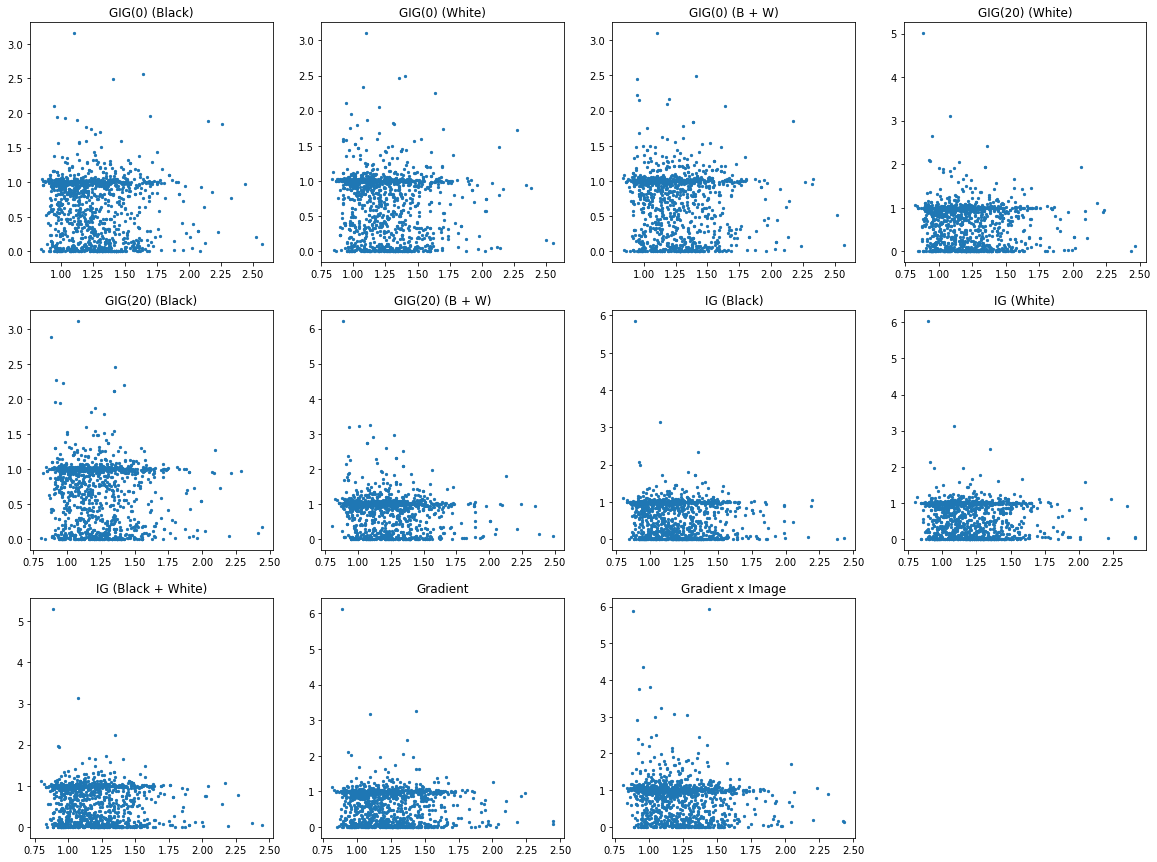

In [87]:
plt.figure(figsize = (20, 15))
labels = [
    'GIG(0) (Black)',
    'GIG(0) (White)',
    'GIG(0) (B + W)',
    'GIG(20) (White)',
    'GIG(20) (Black)',
    'GIG(20) (B + W)',
    'IG (Black)',
    'IG (White)',
    'IG (Black + White)',
    'Gradient',
    'Gradient x Image'
]
for idx in range(11):
    plt.subplot(3, 4, idx + 1)
    plt.scatter(*tmp[:, idx].T, s = 5)
    plt.title(labels[idx])
plt.show()